In [1]:
from DISPLAY import plot_changepoint_comparison, summarize_and_plot_total_cps, boxplot_cps
import os
import random
import pandas as pd

In [2]:
dataset = 'artificial_changepoints'

DIRS_PARA_COMPARAR = {
    # 'Agregação Mean': dataset + '/mean',
    # 'Agregação Bayes': dataset + '/multiplicativa',
    # 'Agregação Log (D_KL média)': dataset + '/logaritmica_KL',
    # 'Agregação Log (H)': dataset + '/logaritmica_H',
    'Label': 'cenario_1',
}

VARIABLES = ['value']

g:\Meu Drive\Documentos\01 - Estudos\11 - Mestrado\05 - Dissertação\03 - Desenvolvimento\DISPLAY.py:440: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


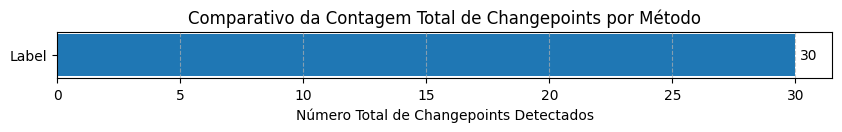

In [3]:
summarize_and_plot_total_cps(DIRS_PARA_COMPARAR)

In [4]:
# selecionar n arquivos aleatórios na pasta do métodos escolhido
def selecionar_arquivos_aleatorios(diretorio, n):
    arquivos = os.listdir(diretorio)
    arquivos_ramdom = random.sample(arquivos, n)
    pares_cliente_servidor = [(arquivo.split('_')[0], arquivo.split('_')[1].replace('.csv','')) for arquivo in arquivos_ramdom]
    return pares_cliente_servidor

def selecionar_todos_os_arquivos(diretorio):
    arquivos = os.listdir(diretorio)
    pares_cliente_servidor = [(arquivo.split('_')[0], arquivo.split('_')[1].replace('.csv','')) for arquivo in arquivos]
    return pares_cliente_servidor

In [5]:
def calculate_cp_metrics_with_margin(source_dirs, ref_method, margin=3):
    """
    Calcula Precision, Recall e F1-Score com uma margem de tolerância.
    
    Parâmetros:
    -----------
    source_dirs : dict
        Dicionário mapeando nomes de métodos para suas pastas de resultados.
    ref_method : str
        A chave (nome do método) em 'source_dirs' que será usada como
        o 'ground truth' (referência).
    margin : int
        A margem de tolerância (em número de pontos/índices) para
        considerar uma detecção como um Verdadeiro Positivo.
    """
    
    variable = 'value' # Hardcoded como você pediu
    cp_col = f"{variable}_cp" 
    
    ref_dir = source_dirs[ref_method]
    test_methods = [m for m in source_dirs if m != ref_method]
    
    # Acumuladores globais
    metrics_summary = {
        method: {'TP': 0, 'FP': 0, 'FN': 0} for method in test_methods
    }

    for file in os.listdir(ref_dir):
        if not file.endswith(".csv"):
            continue
        
        try:
            df_ref = pd.read_csv(os.path.join(ref_dir, file))
        except Exception as e:
            print(f"Erro ao ler arquivo de referência {file}: {e}")
            continue

        gt_cps = set(df_ref.index[df_ref[cp_col] == 1])

        for method_name in test_methods:
            file_path_test = os.path.join(source_dirs[method_name], file)
            
            try:
                df_test = pd.read_csv(file_path_test)
            except FileNotFoundError:
                continue
            except Exception as e:
                print(f"Erro ao ler arquivo de teste {file_path_test}: {e}")
                continue

            if cp_col not in df_test.columns:
                continue 
                    
            pred_cps = set(df_test.index[df_test[cp_col] == 1])
            
            matched_gt = set()
            tp = 0
            
            # Itera sobre os CPs previstos
            for p_cp in pred_cps:
                # Verifica se há um CP de referência dentro da margem
                is_tp = False
                for gt_cp in gt_cps:
                    if abs(p_cp - gt_cp) <= margin:
                        is_tp = True
                        matched_gt.add(gt_cp) # Marca o CP de referência como "encontrado"
                        break
                if is_tp:
                    tp += 1
            
            fp = len(pred_cps) - tp # Falsos Positivos = Previstos - Verdadeiros Positivos
            fn = len(gt_cps - matched_gt) # Falsos Negativos = Referência - Encontrados
                
            metrics_summary[method_name]['TP'] += tp
            metrics_summary[method_name]['FP'] += fp
            metrics_summary[method_name]['FN'] += fn

    final_results = []
    for method_name, counts in metrics_summary.items():
        TP, FP, FN = counts['TP'], counts['FP'], counts['FN']
        
        precision = 0.0 if (TP + FP == 0) else TP / (TP + FP)
        recall = 0.0 if (TP + FN == 0) else TP / (TP + FN)
        f1 = 0.0 if (precision + recall == 0) else 2 * (precision * recall) / (precision + recall)
        
        final_results.append({
            'Método': method_name,
            'Precision': f"{precision:.2%}",
            'Recall': f"{recall:.2%}",
            'F1-Score': f"{f1:.3f}",
            'Total_TP': TP,
            'Total_FP': FP,
            'Total_FN': FN
        })
    
    df_final = pd.DataFrame(final_results)
    print(f"\n--- Resultados da Comparação (vs Referência: {ref_method}, Margem: {margin} pontos) ---")
    print(df_final.to_string())
    
    return df_final

In [6]:
calculate_cp_metrics_with_margin(
    source_dirs=DIRS_PARA_COMPARAR,
    ref_method='Label',
    margin=1
)



--- Resultados da Comparação (vs Referência: Label, Margem: 1 pontos) ---
Empty DataFrame
Columns: []
Index: []


""


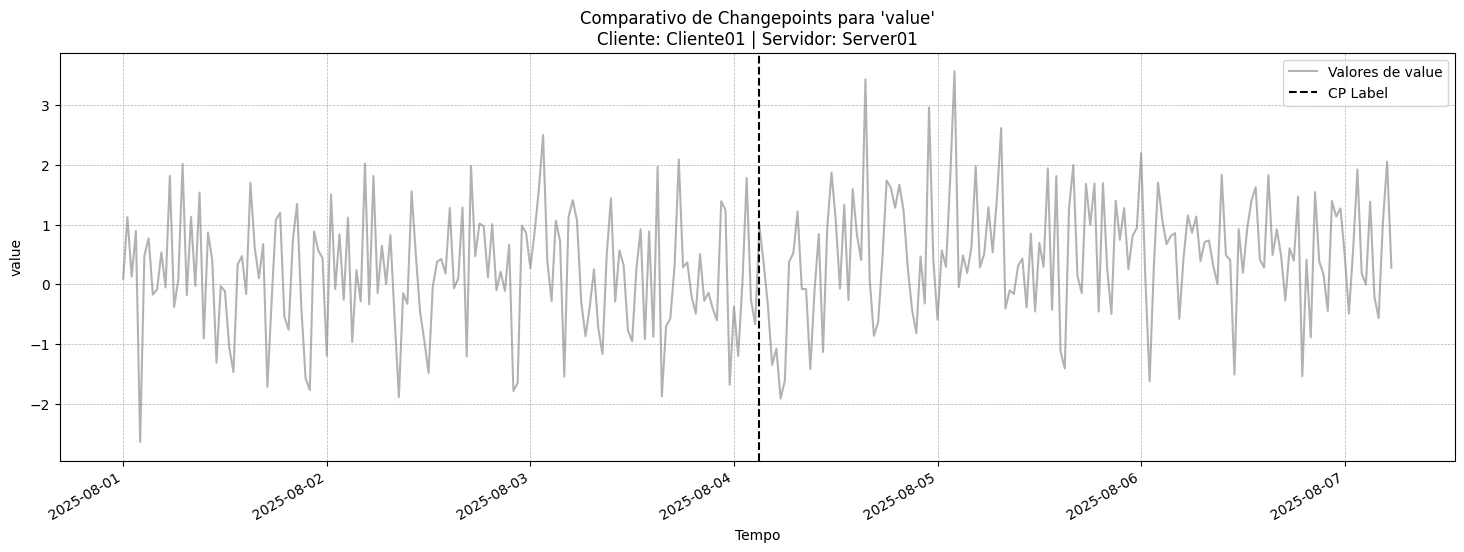

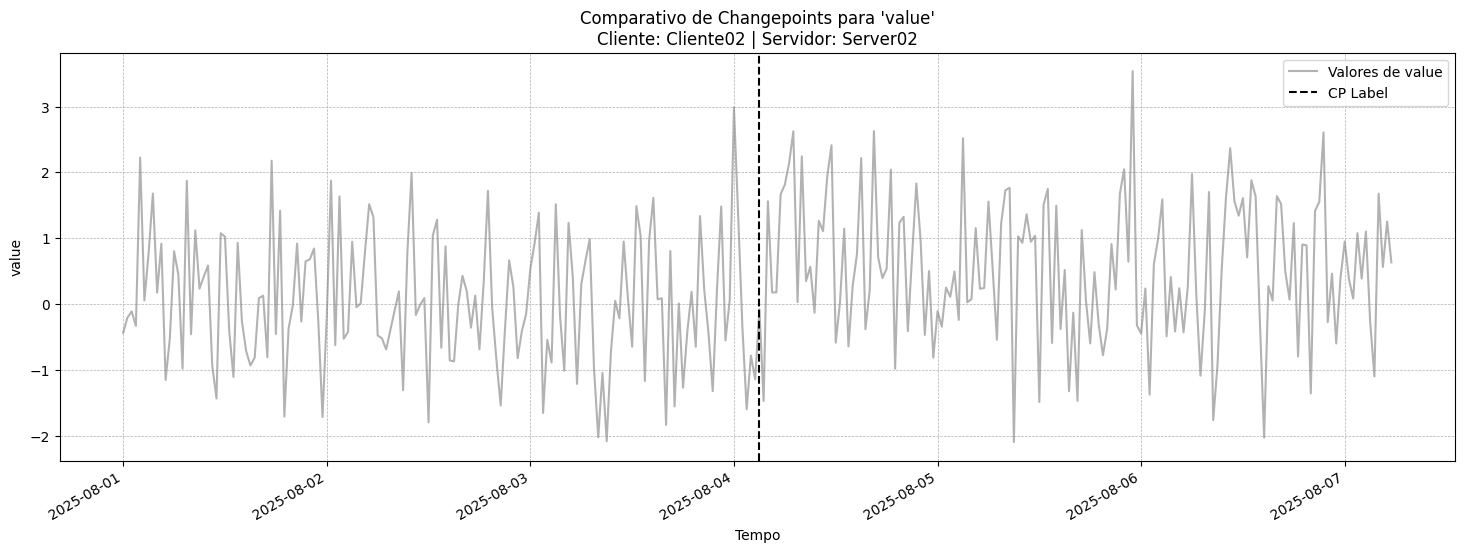

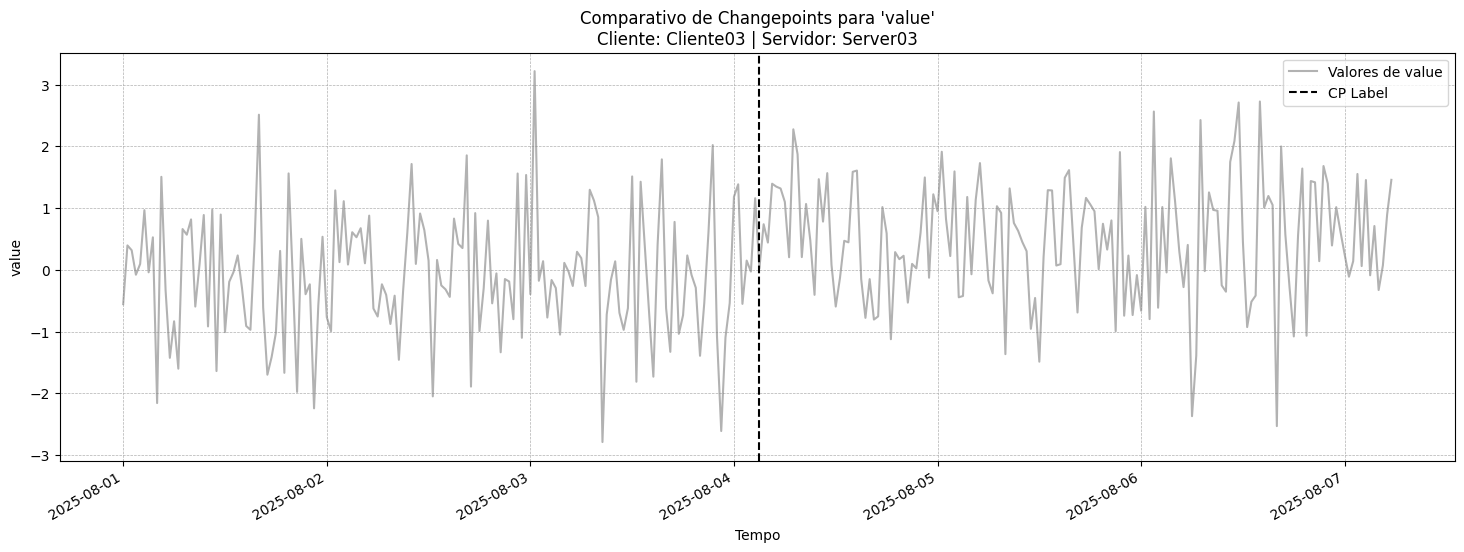

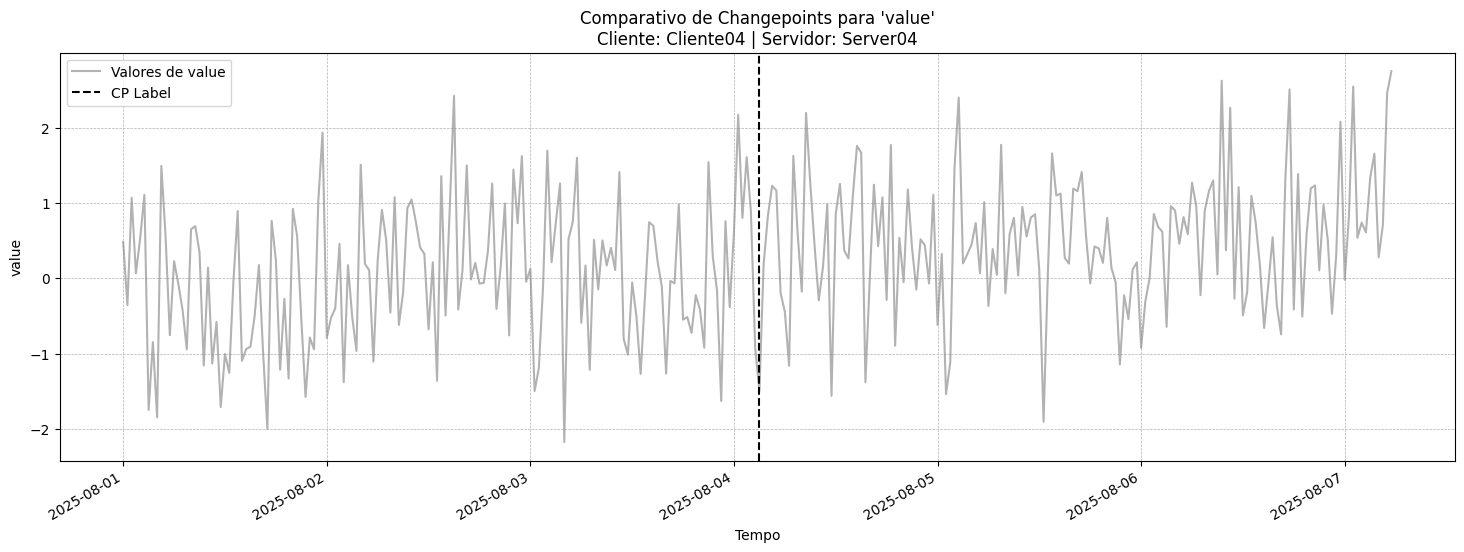

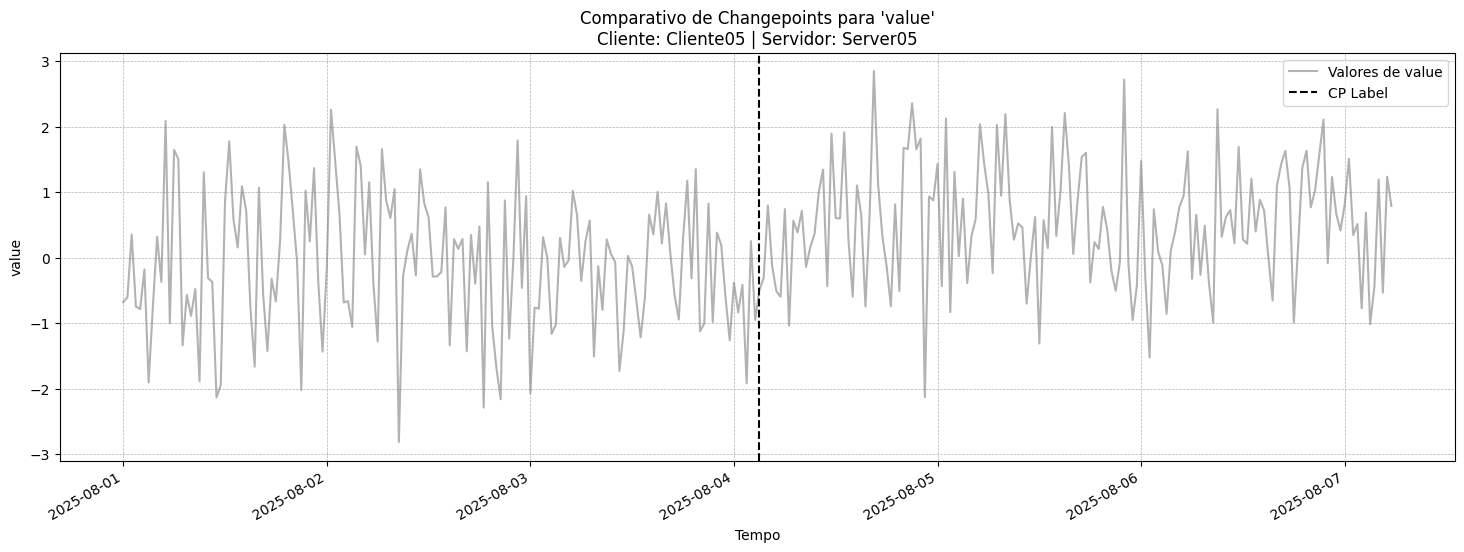

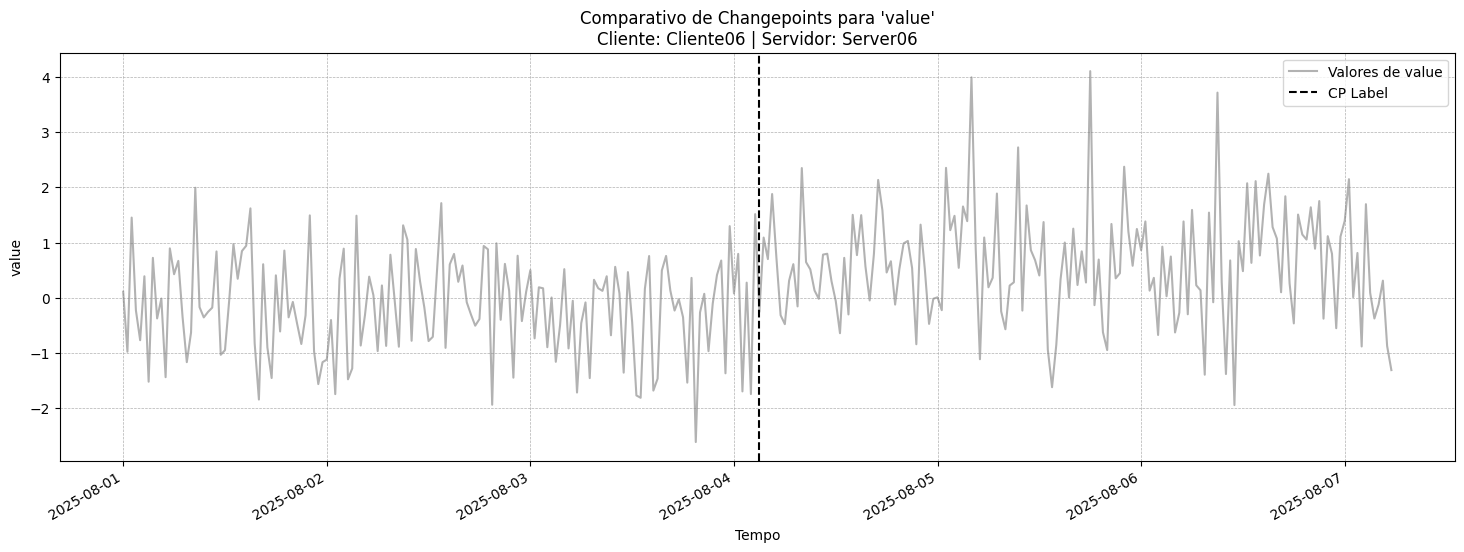

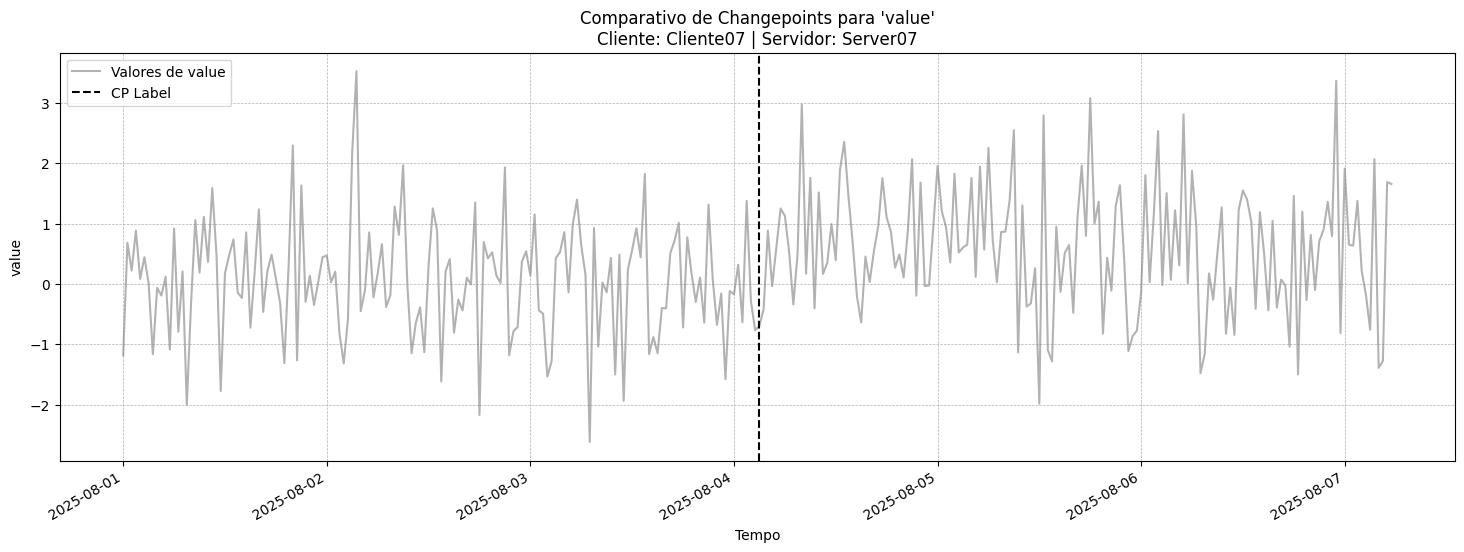

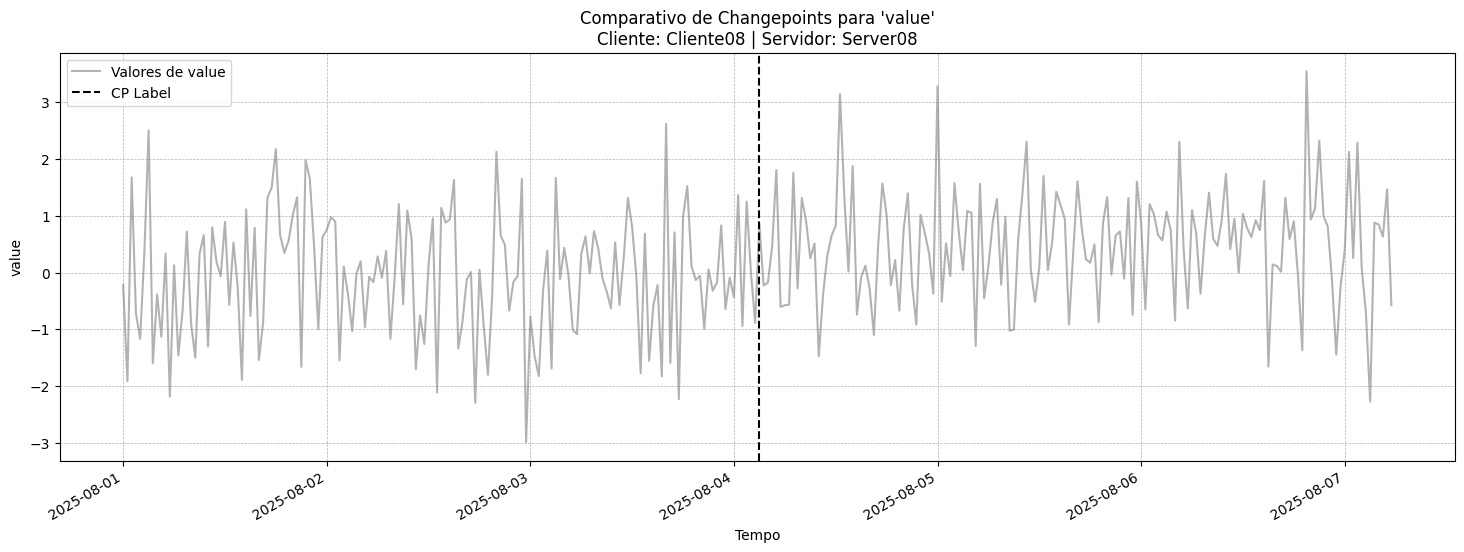

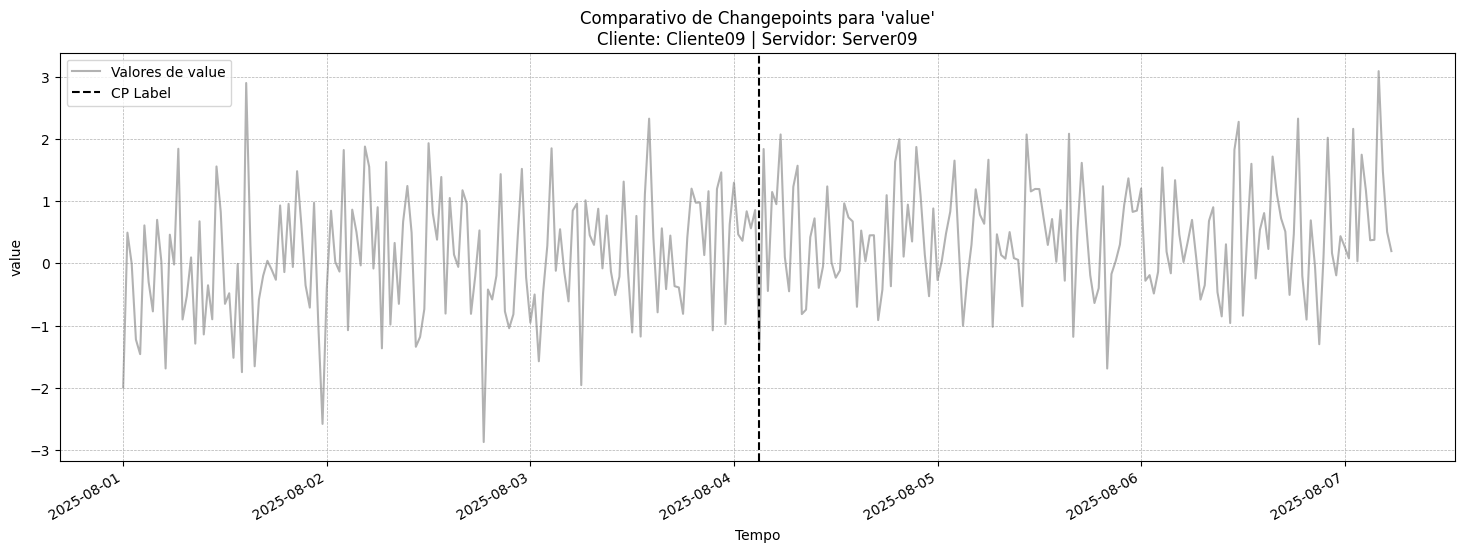

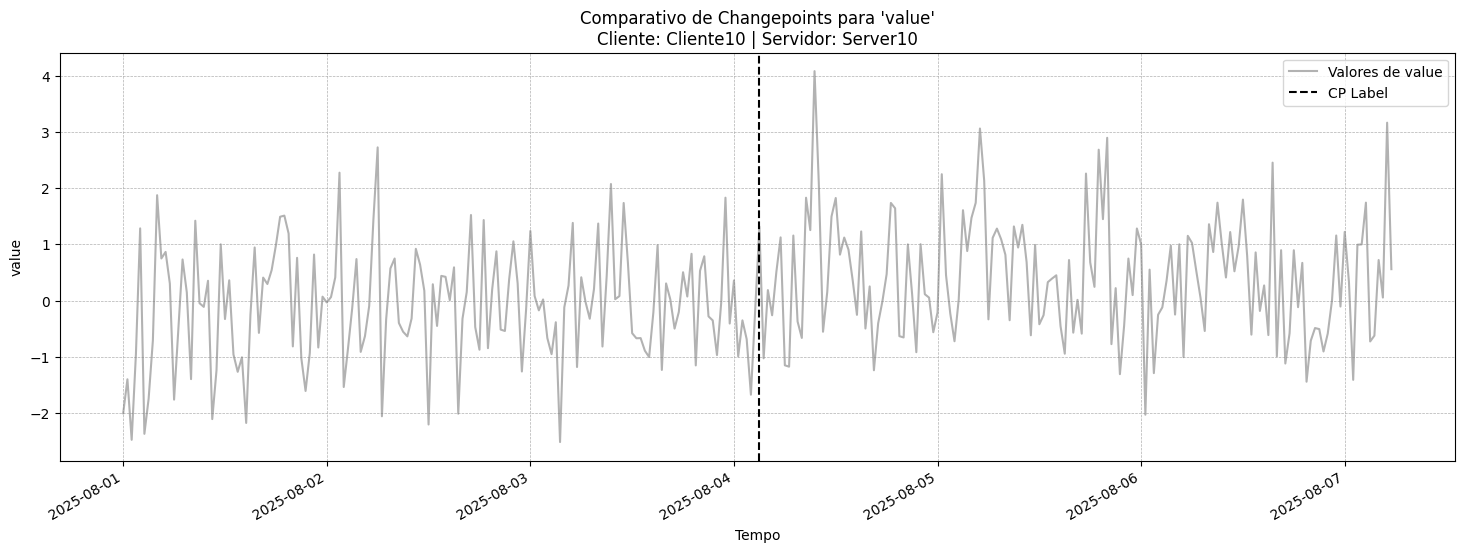

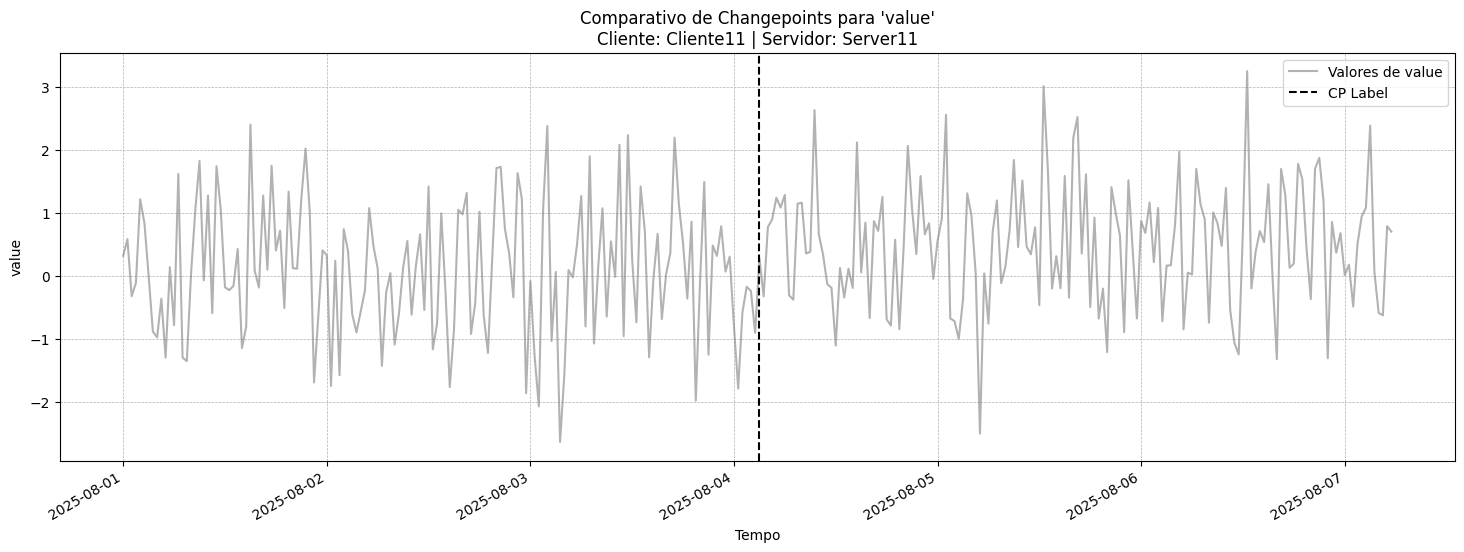

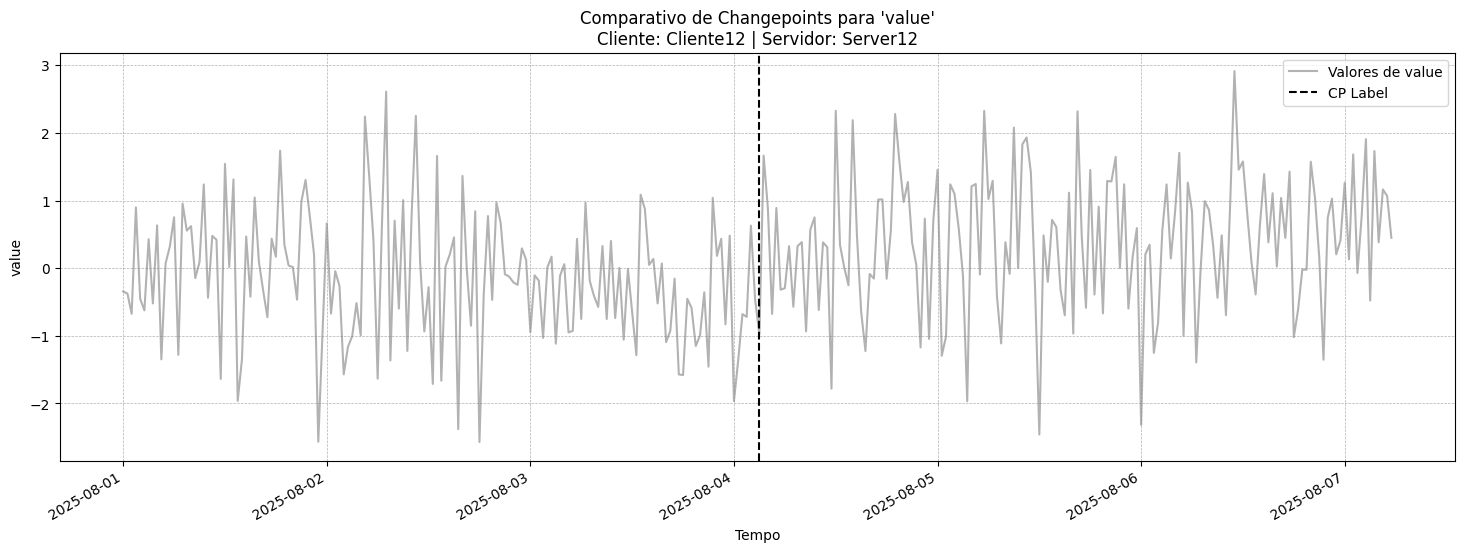

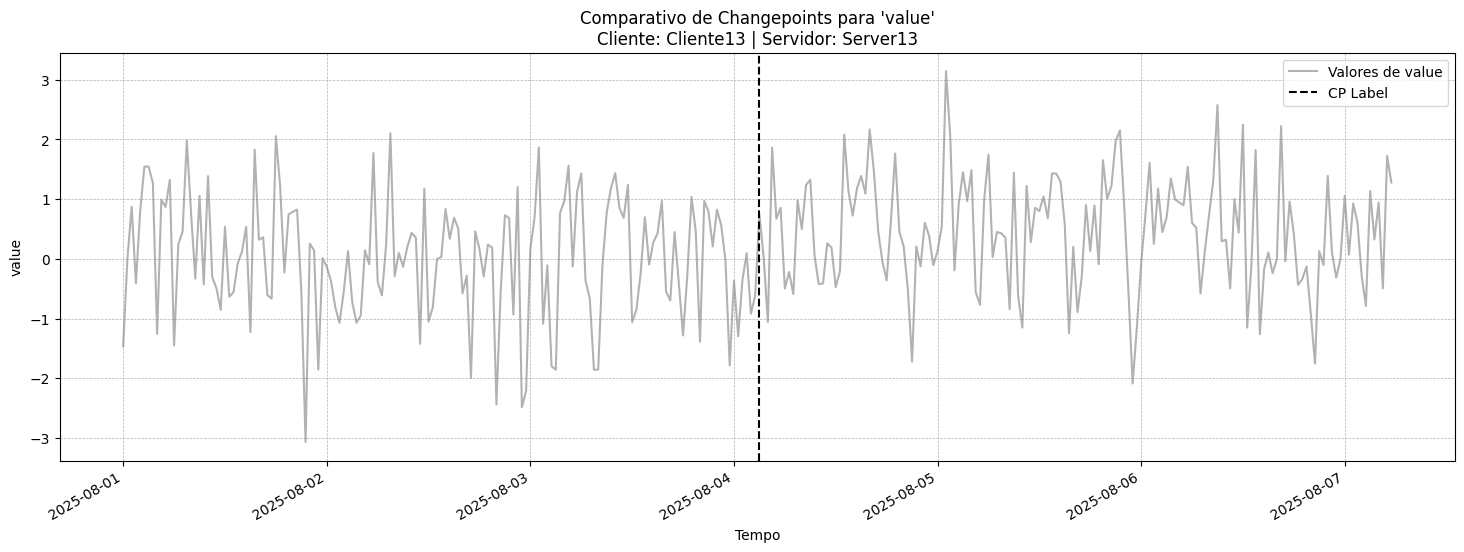

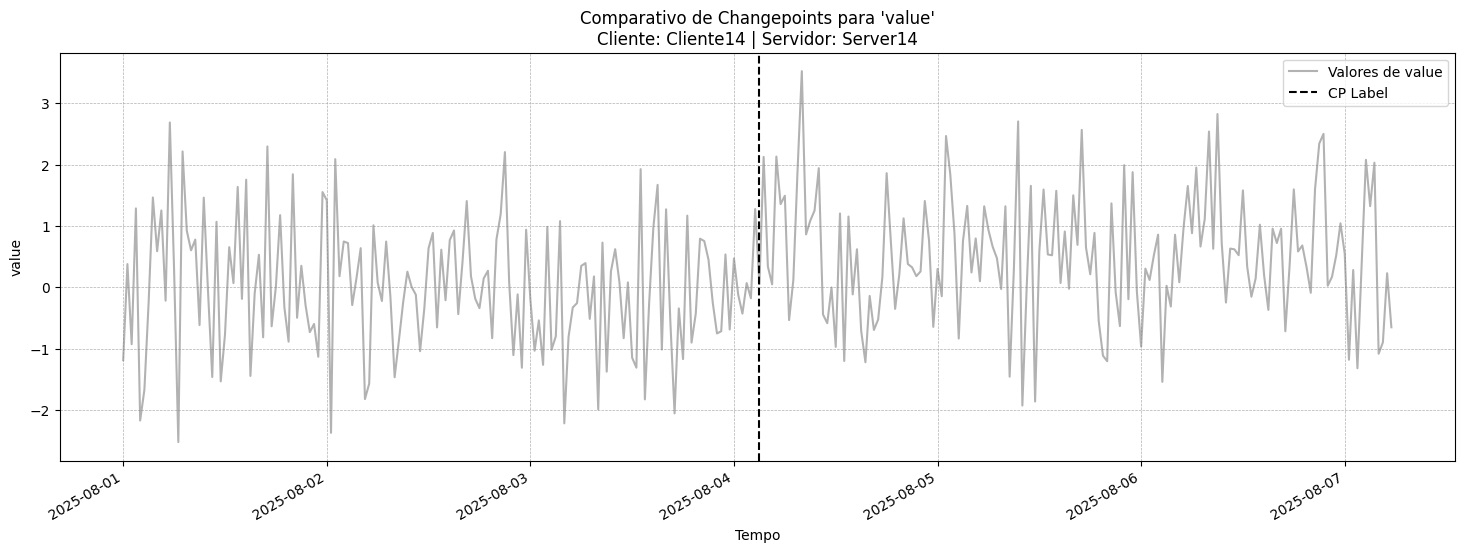

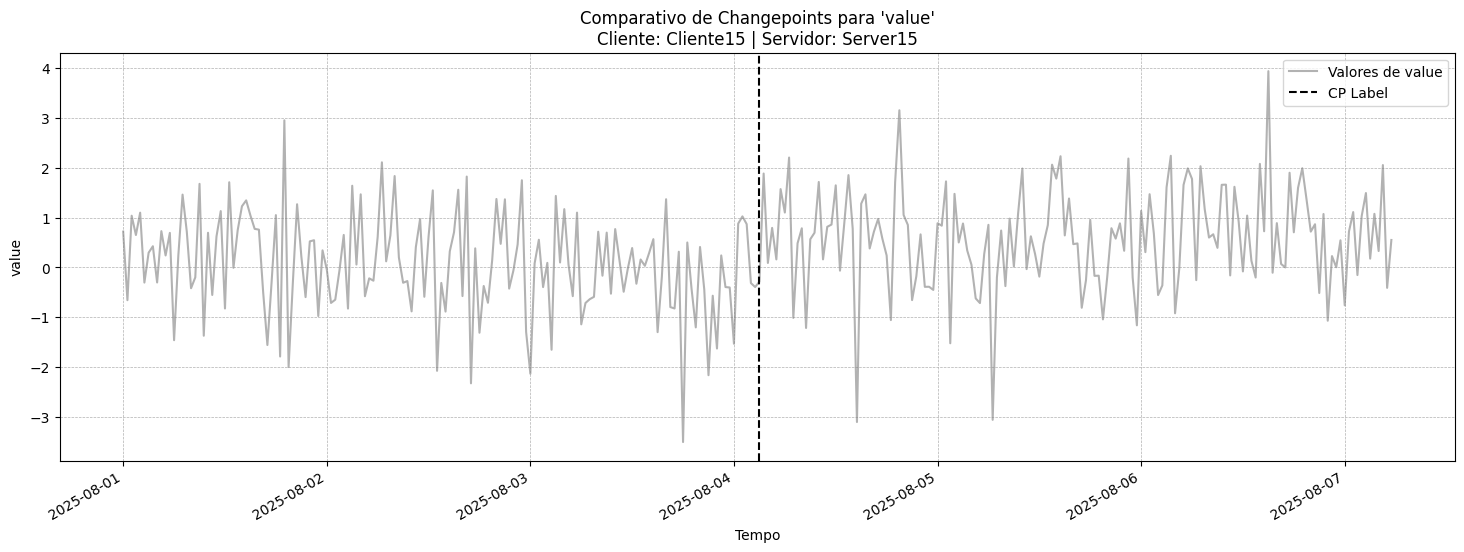

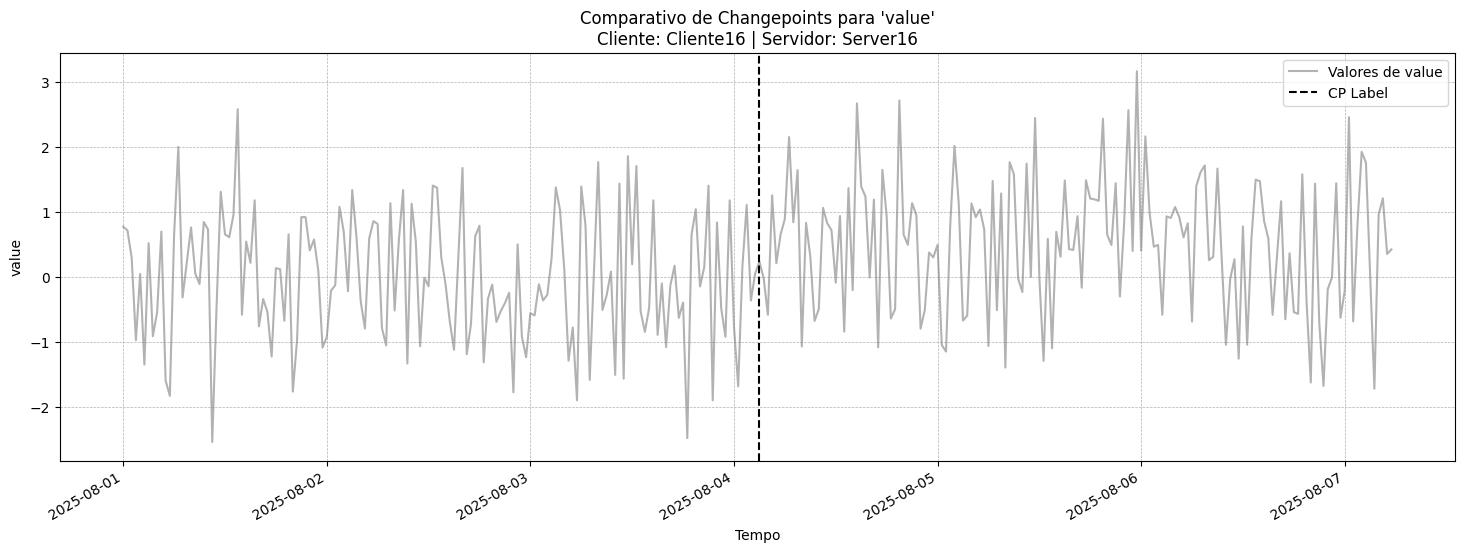

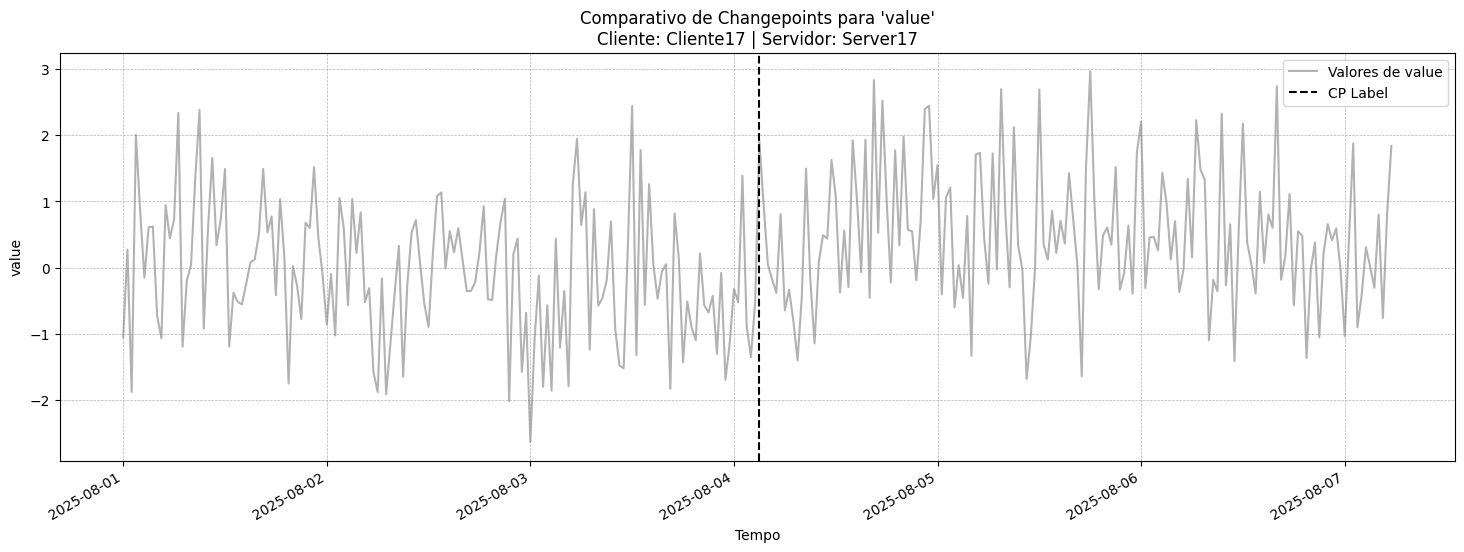

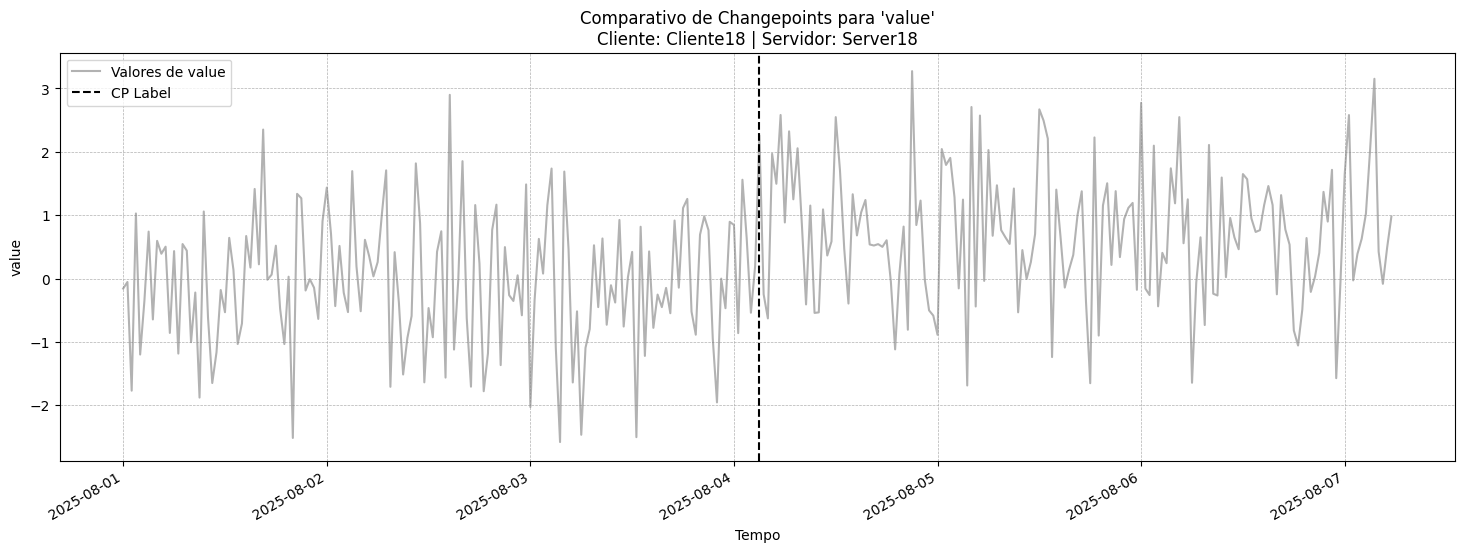

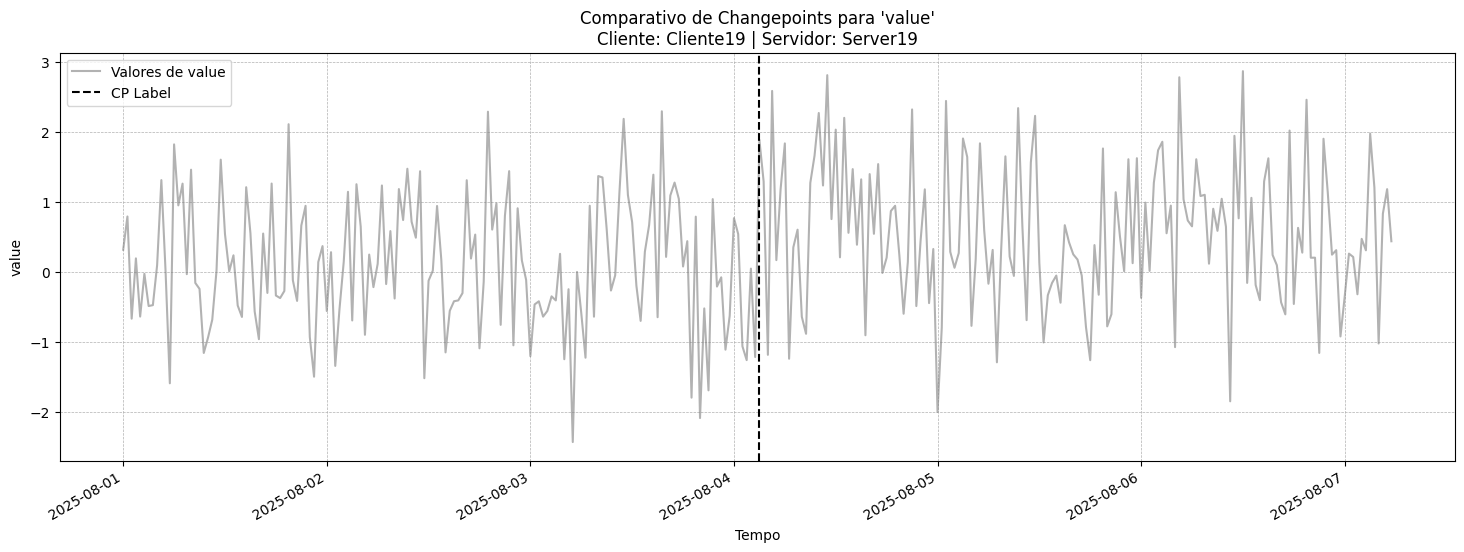

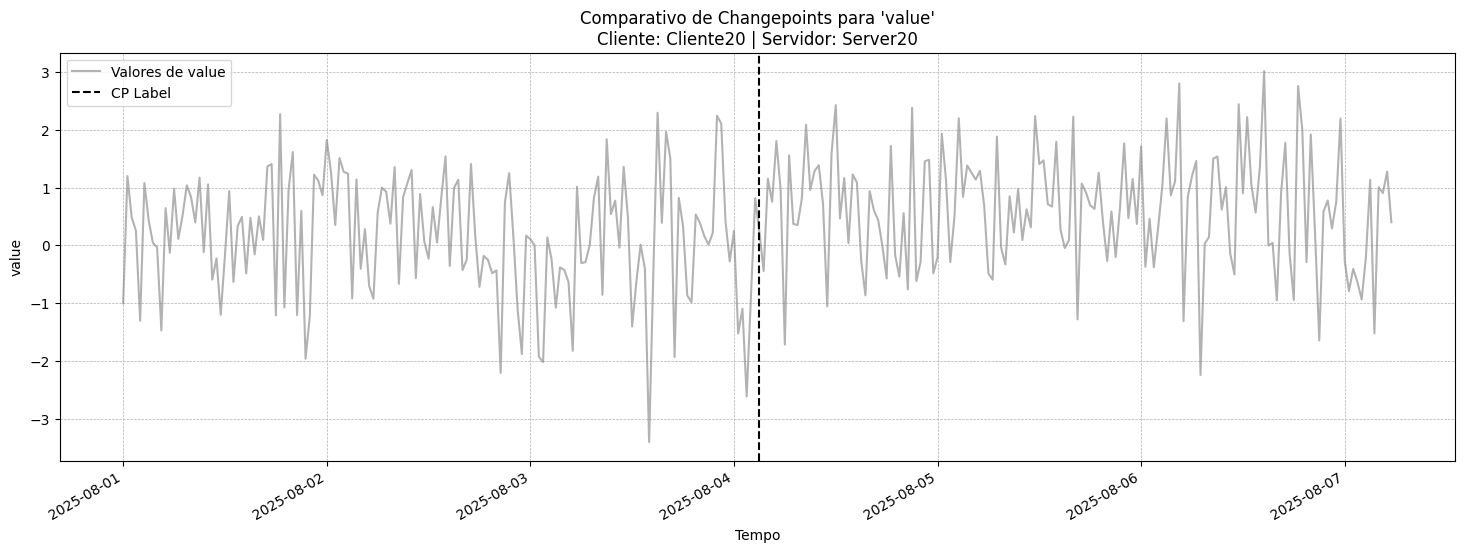

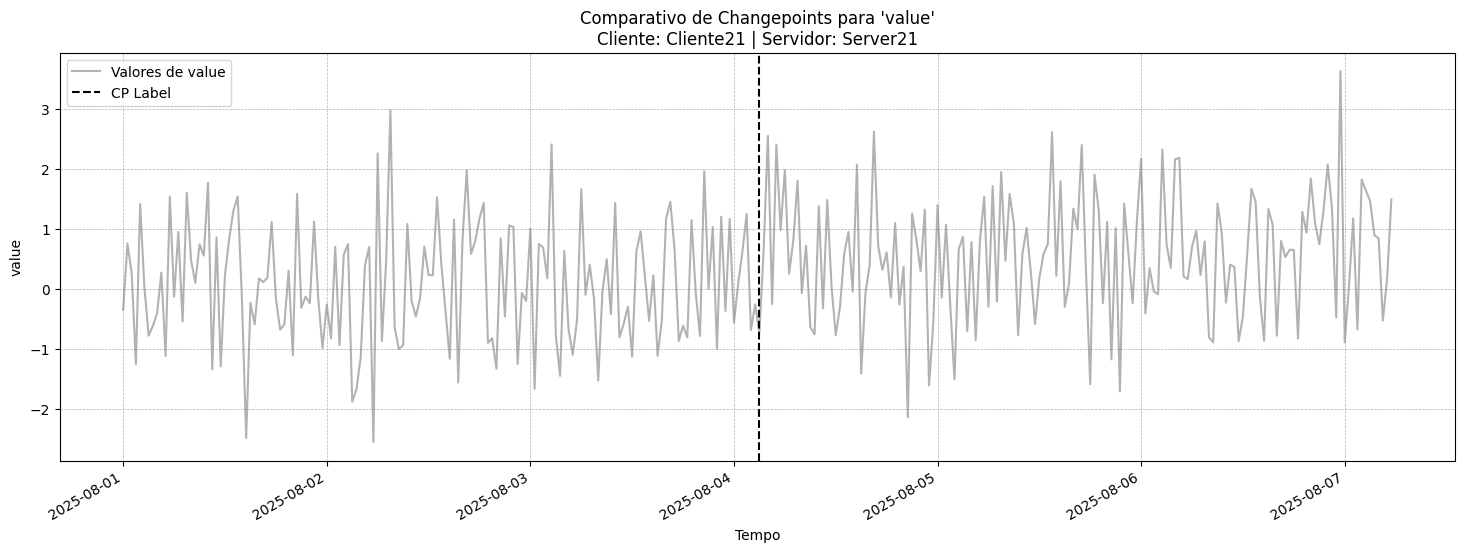

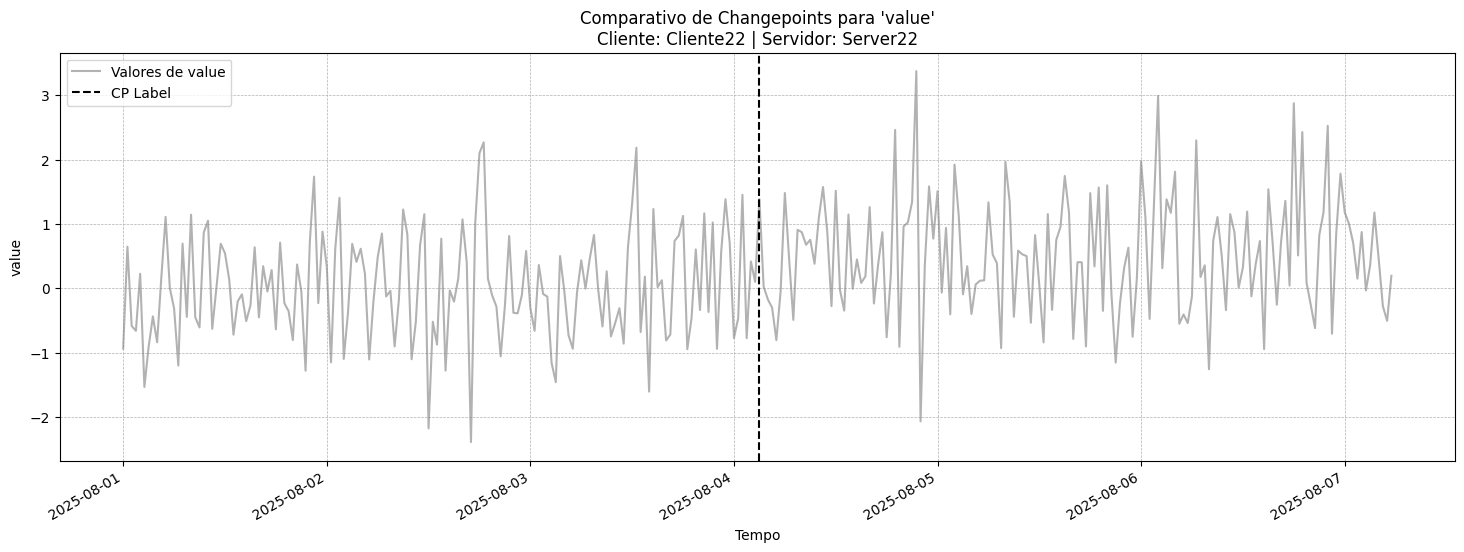

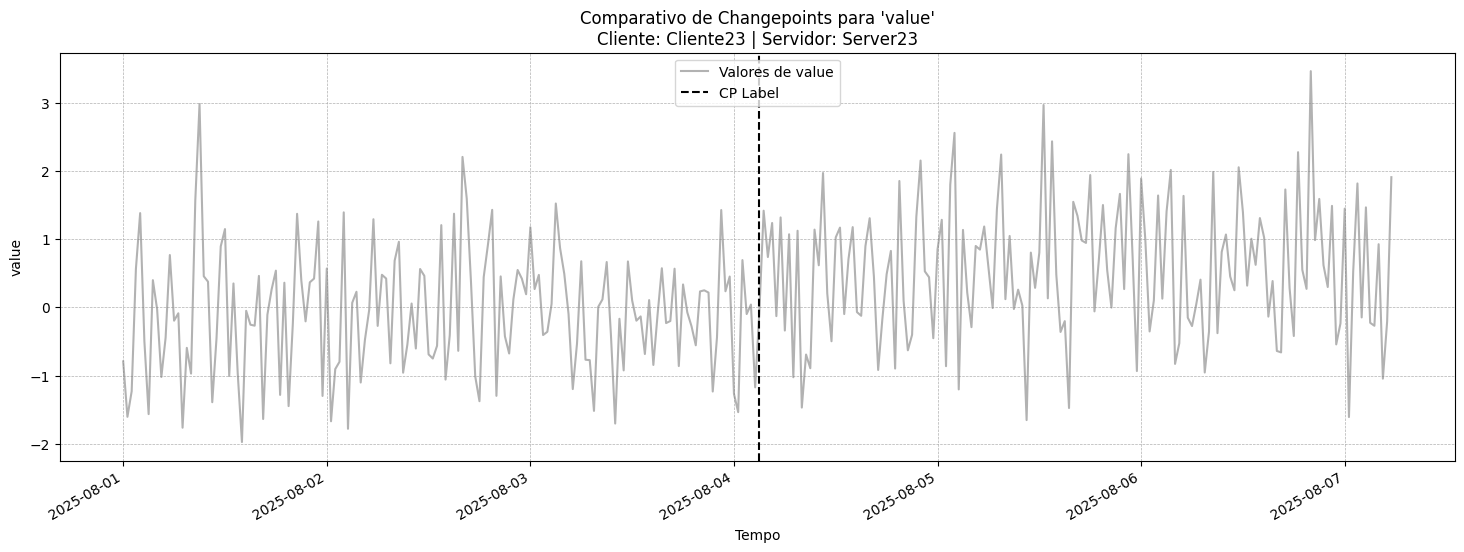

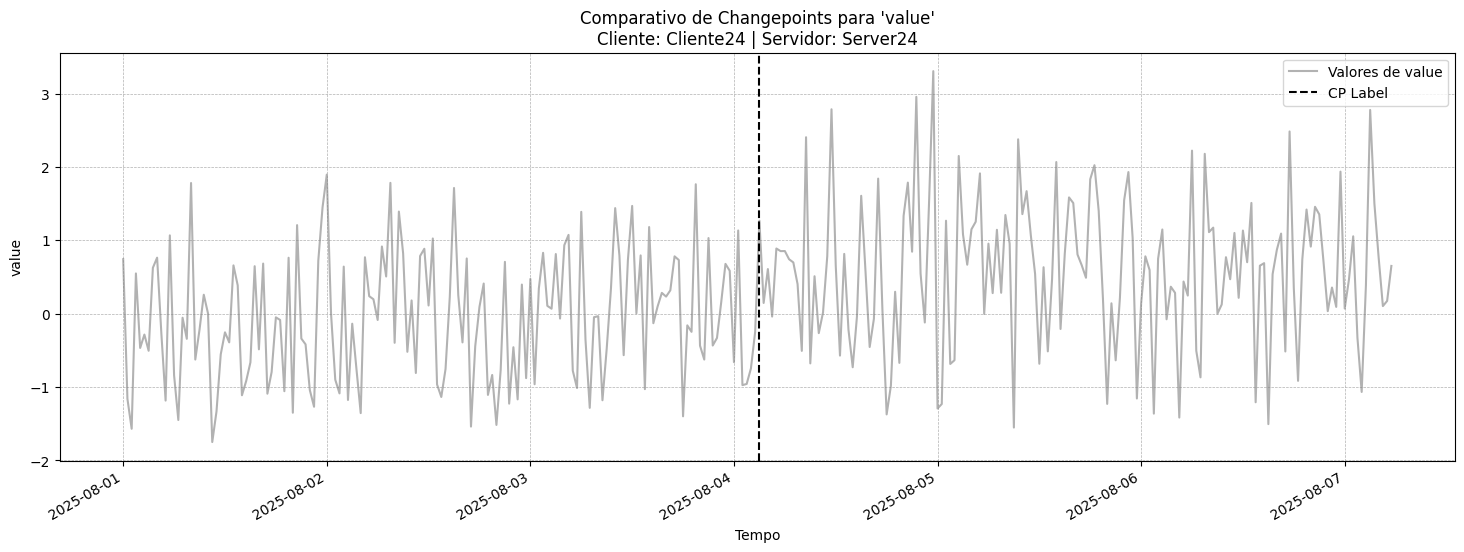

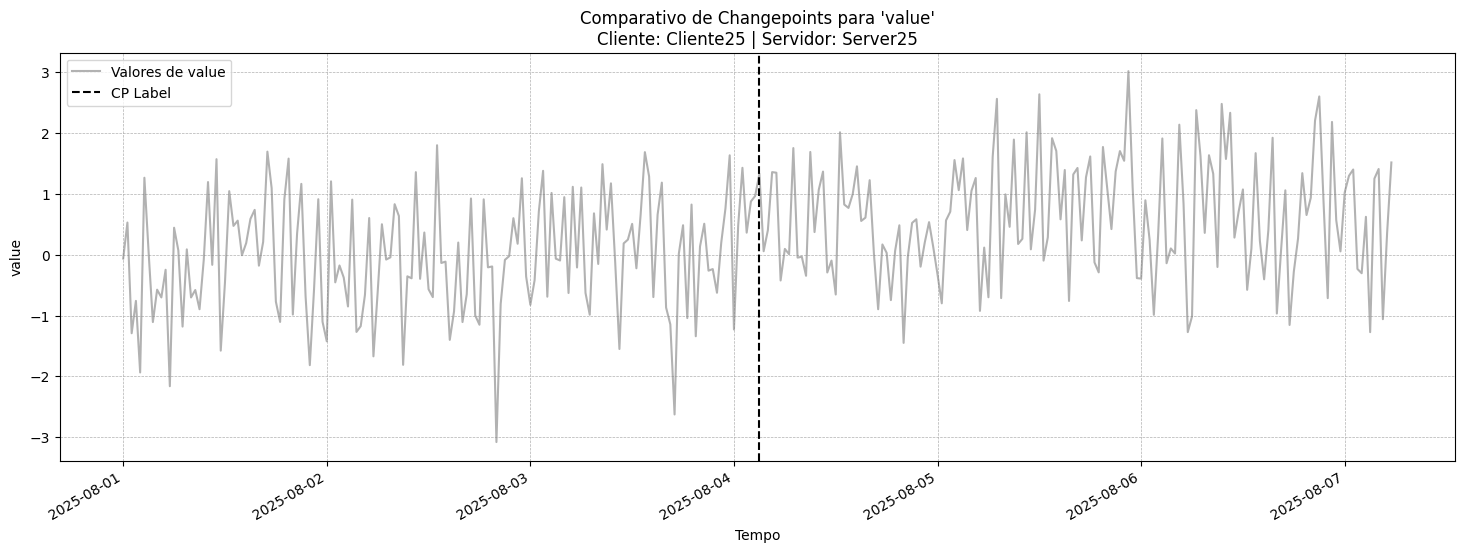

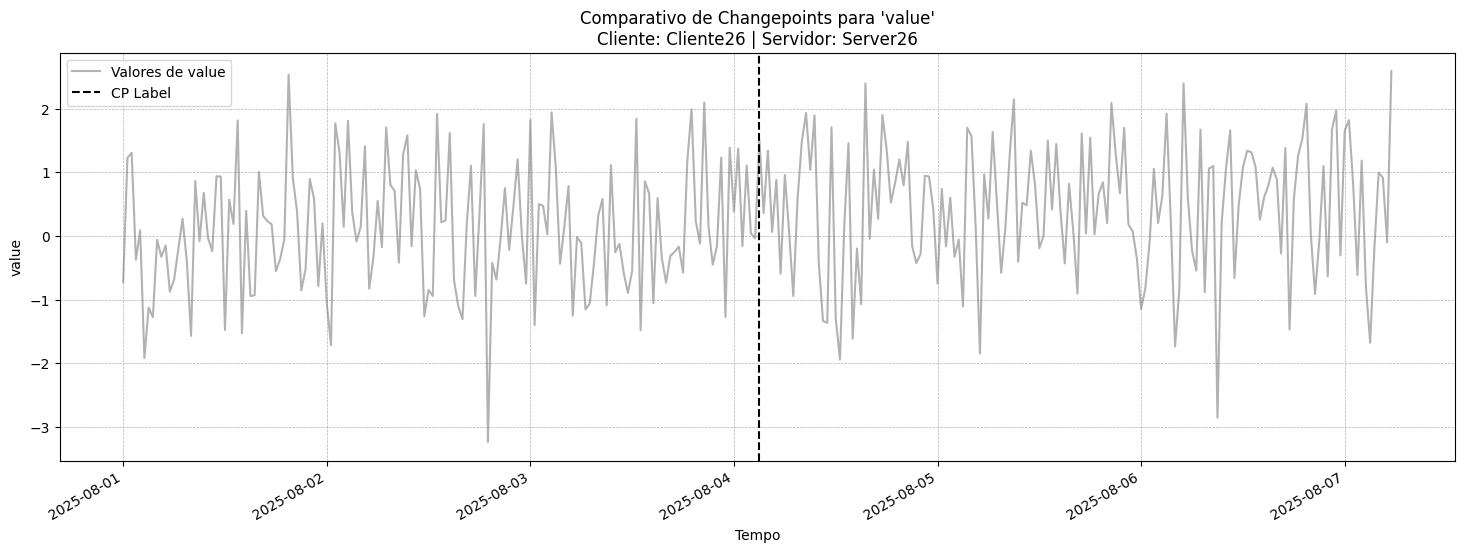

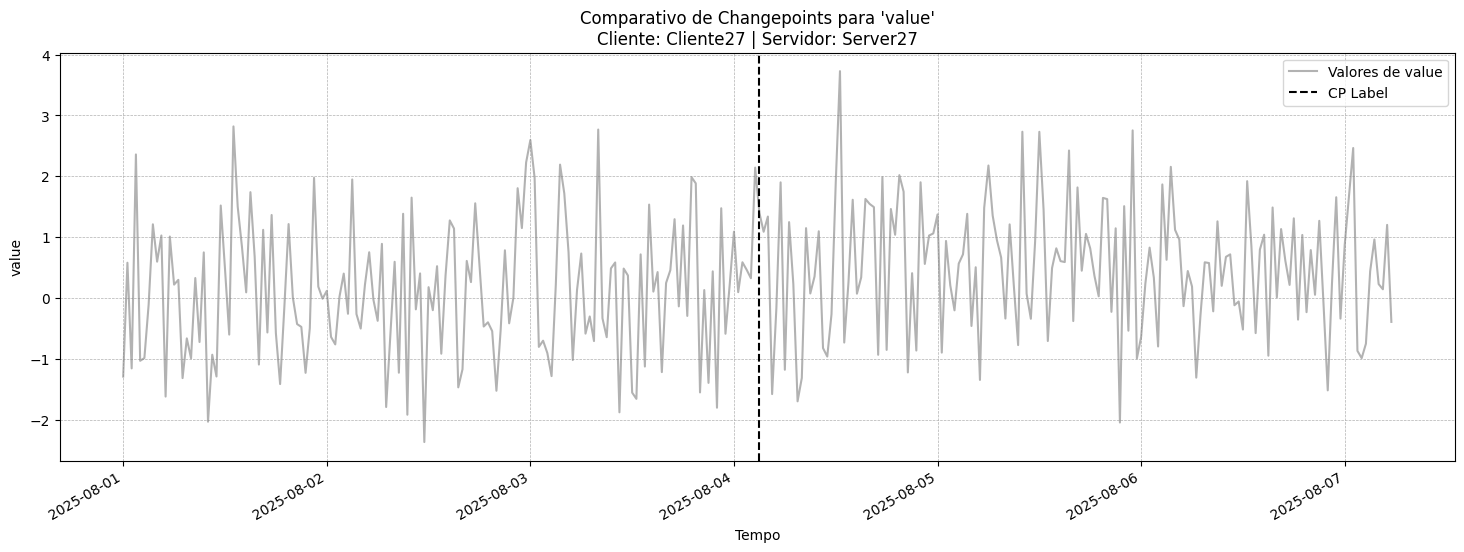

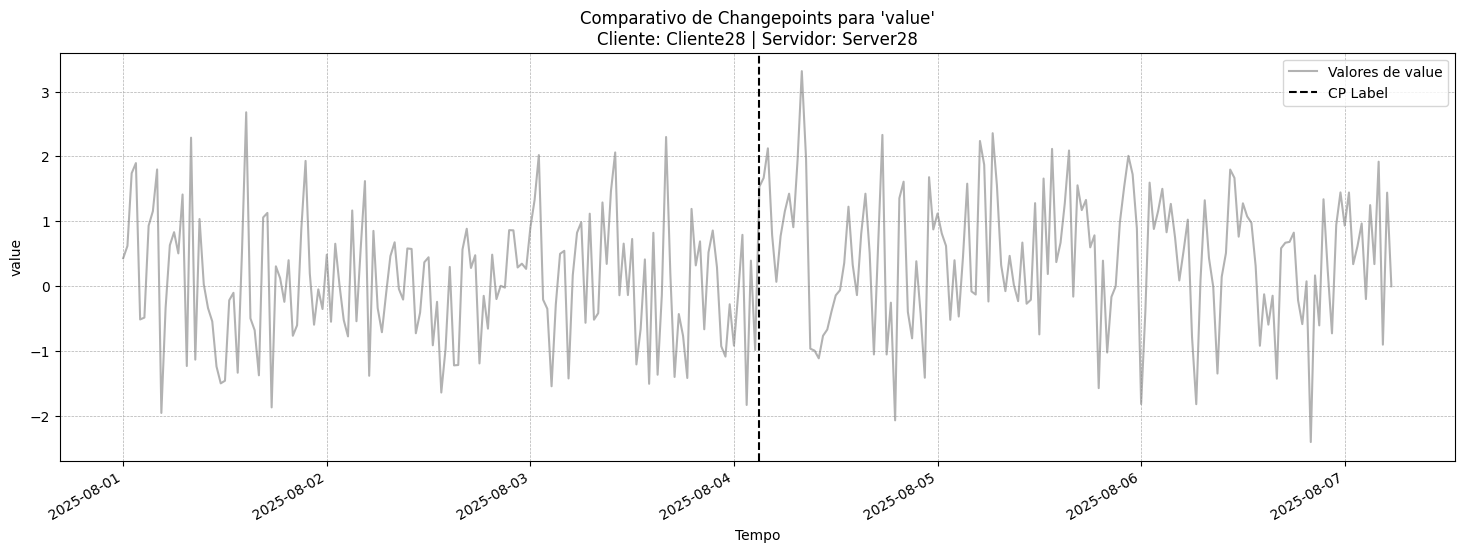

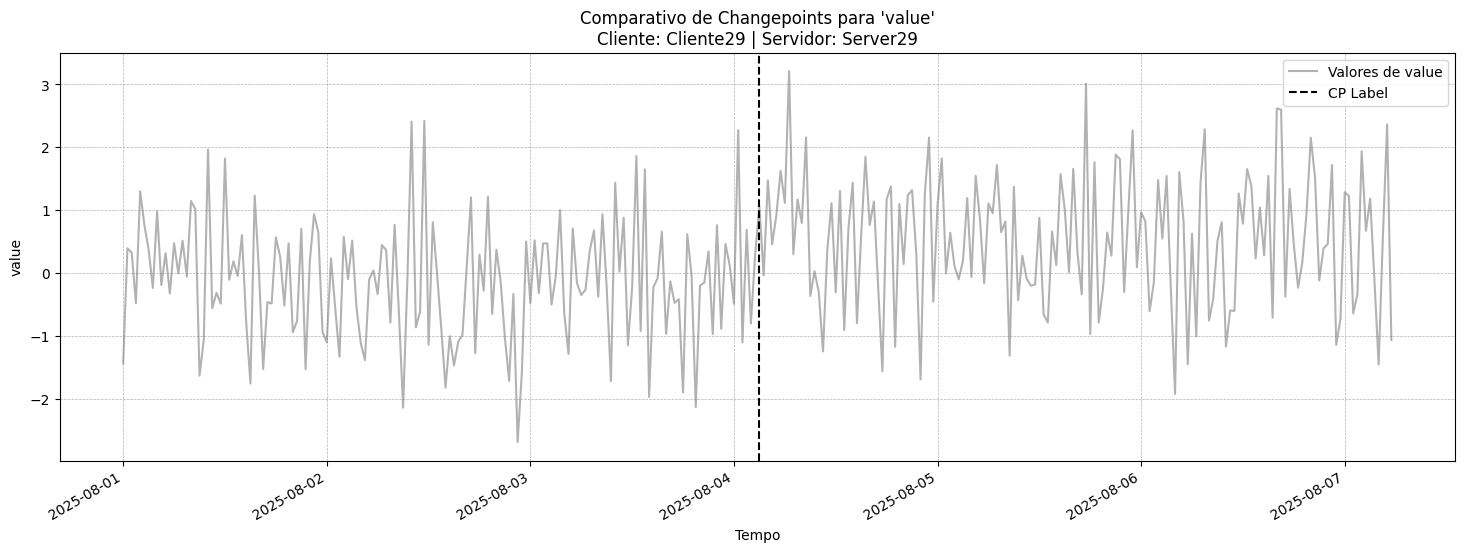

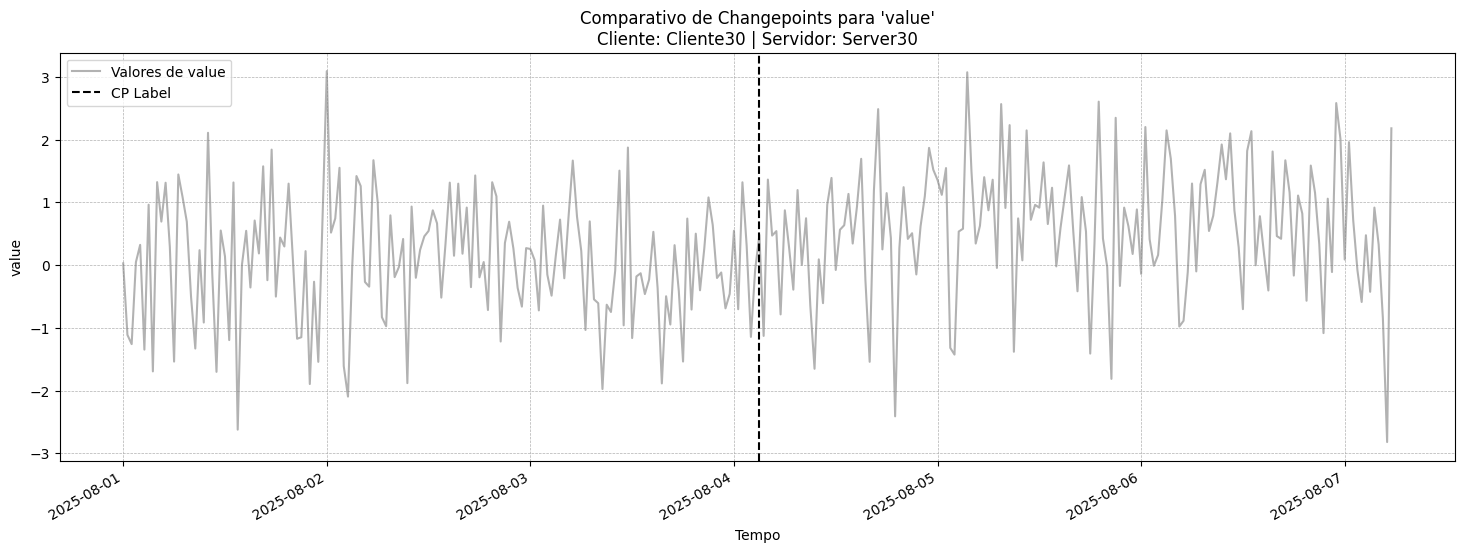

In [7]:
pares = selecionar_todos_os_arquivos('artificial_time_series')

# exclui as imagens antigas na pasta imgs_comparativo
# import os
# diretorio = 'imgs_comparativo'
# for arquivo in os.listdir(diretorio):
#     os.remove(os.path.join(diretorio, arquivo))

for client, server in pares:
    plot_changepoint_comparison(
        source_dirs=DIRS_PARA_COMPARAR,
        client=client,
        server=server,
        variables=VARIABLES,
        save_fig=False,
        ref_method='Label'
    )

# renomeia as imagens salvas em imgs_comparativo para cps_comp_1, cps_comp_2, ...
# diretorio = 'imgs_comparativo'
# arquivos = os.listdir(diretorio)
# for i, arquivo in enumerate(arquivos):
#     extensao = arquivo.split('.')[-1]
#     novo_nome = f'cps_comp_{i+1}.{extensao}'
#     os.rename(os.path.join(diretorio, arquivo), os.path.join(diretorio, novo_nome))